## Fashion sales project

This project aims to gain insights into the fashion market and optimize the selling process by leveraging on the available fashion sales data and using different machine-learning solutions.

#### Workflow of the project
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

In [1]:
# We define all the packages needed to carry out the project
import time
from pickle import dump, load

# --- Data visualization and data analysis ---
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import numpy as np
from scipy.stats import uniform
import pandas as pd
#import prince
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# --- Machine learning models ---
#from sklearn.ensemble import RandomForestClassifier
#from imblearn.ensemble import BalancedRandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cluster import KMeans
#from sklearn.linear_model import LogisticRegression
#from mlxtend.classifier import StackingCVClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%matplotlib inline

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('data/mock_fashion_data_uk_us.csv')

#### 4) Data Pre-processing
- Separate data in predictors (indipendent variables) and responses or targets (dependent variables)
- Apply the corresponding transformation on each variable
- Check correlation between predictors
- Split data in training and validation dataset

In [3]:
# Predictors
X = df.drop(columns=['Product Name', 'Price'], axis=1)

# We will use as a response variable the price of the clothes
y = df['Price']

In [4]:
# Check if it was done correctly
X.head()

,Brand,Category,Description,Rating,Review Count,Style Attributes,Total Sizes,Available Sizes,Color,Purchase History,Age,Fashion Magazines,Fashion Influencers,Season,Time Period Highest Purchase,Customer Reviews,Social Media Comments,feedback
0,Ralph Lauren,Footwear,Bad,1.421706,492,Streetwear,"M, L, XL",XL,Green,Medium,24,Vogue,Chiara Ferragni,Fall/Winter,Daytime,Mixed,Mixed,Other
1,Ted Baker,Tops,Not Good,1.037677,57,Vintage,"M, L, XL",XL,Black,Above Average,61,Glamour,Leandra Medine,Winter,Weekend,Negative,Neutral,Other
2,Jigsaw,Footwear,Very Bad,3.967106,197,Streetwear,"S, M, L",M,Blue,Average,27,Marie Claire,Gigi Hadid,Summer,Nighttime,Unknown,Negative,Neutral
3,Alexander McQueen,Outerwear,Not Good,2.844659,473,Formal,"S, M, L",L,Red,Very High,50,Marie Claire,Chiara Ferragni,Fall/Winter,Weekend,Neutral,Other,Other
4,Tommy Hilfiger,Bottoms,Very Good,1.183242,55,Sporty,"M, L, XL",S,Green,Above Average,23,Glamour,Song of Style,Spring,Daytime,Positive,Mixed,Positive


In [5]:
# Separete between numerical and categorical features
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Instantiate transformers
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

# Create a Column Transformer with 2 types of transformers
preprocessor = ColumnTransformer([("OneHotEncoder", oh_transformer, cat_features),
                                  ("StandardScaler", numeric_transformer, num_features),])

In [6]:
# Apply transformations on predictors
X = preprocessor.fit_transform(X)

In [7]:
# Convert transformed predictors into pandas DataFrame
testing_X = pd.DataFrame(X.toarray())

In [8]:
# Compute the correlation matrix
correlation_matrix = testing_X.corr()

In [26]:
# Correlation between predictors and response
for column in testing_X.columns:
    print(pd.concat((testing_X[[column]], y), axis=1).corr())

              0     Price
0      1.000000  0.001596
Price  0.001596  1.000000
              1     Price
1      1.000000  0.002651
Price  0.002651  1.000000
              2     Price
2      1.000000  0.000216
Price  0.000216  1.000000
              3     Price
3      1.000000 -0.000894
Price -0.000894  1.000000
              4     Price
4      1.000000 -0.001711
Price -0.001711  1.000000
             5    Price
5      1.00000  0.00128
Price  0.00128  1.00000
              6     Price
6      1.000000 -0.001819
Price -0.001819  1.000000
              7     Price
7      1.000000 -0.001323
Price -0.001323  1.000000
              8     Price
8      1.000000 -0.000368
Price -0.000368  1.000000
              9     Price
9      1.000000  0.000228
Price  0.000228  1.000000
             10     Price
10     1.000000  0.000739
Price  0.000739  1.000000
             11     Price
11     1.000000 -0.001266
Price -0.001266  1.000000
            12    Price
12     1.00000  0.00115
Price  0.00115  1.0000

In [9]:
# List of correlation values
correlation_values = []

# Getting the correlation values from the lower triangle of the correlation matrix
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1):
        correlation_values.append(correlation_matrix.to_numpy()[i,j])
        
# Convertion to numpy array
correlation_values = np.array(correlation_values)

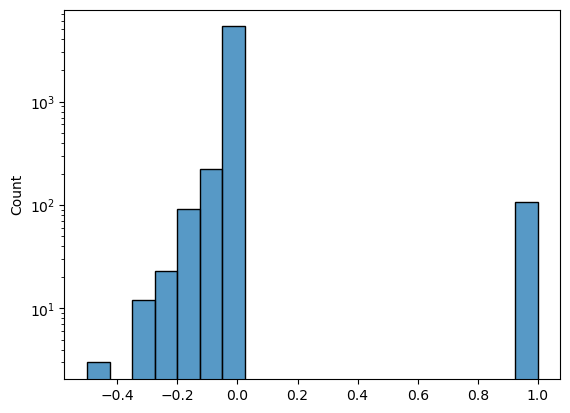

In [10]:
# Histogram to see the distribution of correlation values given the huge number of them
sns.histplot(correlation_values, bins=20)
plt.yscale('log')

In [11]:
# Separate dataset into training and validation data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_validation.shape

((800000, 107), (200000, 107))

#### 5) Model Training
- Choose the models to be used
- Perform a hyperparameter tunning
- Save the best-fit hyperparameters
- Choose the best-fit hyperparameters to train the models

In [19]:
# Dictionary of models. Each value corresponds to a list whose firts element is the learning algorithm and the second one is
# the dictionary of values to perform the randomized search
models = {
    "Linear Regression": LinearRegression(n_jobs = 8),
    "Lasso": [Lasso(), dict(alpha = np.logspace(-2, 2, 100, dtype=np.float32), 
                            max_iter = np.arange(500, 2000, 1, dtype=np.int32), 
                            tol = np.logspace(-6, -3, 100, dtype=np.float32),
                            warm_start = [True, False])],
    "Ridge": [Ridge(), dict(alpha = np.logspace(-2, 2, 100, dtype=np.float32),
                            tol = np.logspace(-6, -3, 100, dtype=np.float32),
                            solver = ['auto', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'])],
    "K-Neighbors Regressor": [KNeighborsRegressor(n_jobs = 8), dict(n_neighbors = np.arange(3, 100, 1, dtype=np.int32),
                                                                  weights = ['uniform', 'distance'],
                                                                  algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                                  leaf_size = np.arange(20, 75, 1, dtype=np.int32))],
    "Decision Tree Regressor": [DecisionTreeRegressor(random_state = 10), dict(criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                                                                               max_depth = np.arange(1, 10, 1, dtype=np.int32),
                                                                               min_samples_split = np.linspace(0.05, 1.0, 20),
                                                                               min_samples_leaf = np.linspace(0.05, 0.5, 20),
                                                                               max_features = np.arange(1, X_train.shape[1], 1, dtype=np.int32),
                                                                               max_leaf_nodes = np.arange(2, 10, 1, dtype=np.int32),
                                                                               min_impurity_decrease = [0.0, 0.5, 1.0])],
    "Random Forest Regressor": [RandomForestRegressor(n_jobs = 8, random_state = 10), dict(n_estimators = np.arange(50, 1000, 1, dtype=np.int32),
                                                                      criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
                                                                      max_depth = np.arange(1, 10, 1, dtype=np.int32),
                                                                      min_samples_split = np.linspace(0.05, 1.0, 20),
                                                                      min_samples_leaf = np.linspace(0.05, 1.0, 20),
                                                                      max_features = np.arange(1, X_train.shape[1], 1, dtype=np.int32),
                                                                      max_leaf_nodes = np.arange(1, 10, 1, dtype=np.int32),
                                                                      min_impurity_decrease = [0.0, 0.5, 1.0],
                                                                      bootstrap = [True, False],
                                                                      ccp_alpha = np.linspace(0.0, 0.3, 20),
                                                                      max_samples = np.linspace(0.05, 1.0, 20))],
    "XGBRegressor": [XGBRegressor(n_jobs = 8, random_state = 10, device = 'cpu', eval_metric = r2_score), dict(n_estimators = np.arange(50, 1000, 1, dtype=np.int32),
                                          max_depth = np.arange(1, 10, 1, dtype=np.int32),
                                          max_leaves = np.arange(0, 5000, 1, dtype=np.int32),
                                          grow_policy = ['depthwise', 'lossguide'],
                                          learning_rate = np.logspace(-3, 2, 60),
                                          booster = ['gbtree', 'gblinear', 'dart'],
                                          reg_alpha = np.logspace(-3, 2, 60),
                                          reg_lambda = np.logspace(-3, 2, 60),
                                          colsample_bytree = np.linspace(0.05, 1.0, 20))],
    "CatBoosting Regressor": [CatBoostRegressor(verbose=False, loss_function = 'RMSE', random_state = 10), dict(learning_rate = np.logspace(-3, 2, 60),
                                                                     max_depth = np.arange(1, 10, 1, dtype=np.int32))],
    "AdaBoost Regressor": [AdaBoostRegressor(random_state = 10), dict(n_estimators = np.arange(25, 200, 1, dtype=np.int32),
                                                                      learning_rate = np.logspace(-3, 1, 50),
                                                                      loss = ['linear', 'square', 'exponential'])]
}

# Some metrics for XGBRegressor: mean_squared_error, mean_absolute_error, mean_gamma_deviance, r2_score

In [20]:
# Dictionary with the RandomizedSearchCV object's instance for each model
randomized_search_objects = {"Lasso": RandomizedSearchCV(models["Lasso"][0], models["Lasso"][1], random_state = 1),
                             "Ridge": RandomizedSearchCV(models["Ridge"][0], models["Ridge"][1], random_state = 2),
                             "K-Neighbors Regressor": RandomizedSearchCV(models["K-Neighbors Regressor"][0], models["K-Neighbors Regressor"][1], random_state = 3),
                             "Decision Tree Regressor": RandomizedSearchCV(models["Decision Tree Regressor"][0], models["Decision Tree Regressor"][1], random_state = 4),
                             "Random Forest Regressor": RandomizedSearchCV(models["Random Forest Regressor"][0], models["Random Forest Regressor"][1], random_state = 5),
                             "XGBRegressor": RandomizedSearchCV(models["XGBRegressor"][0], models["XGBRegressor"][1], random_state = 6),
                             "CatBoosting Regressor": RandomizedSearchCV(models["CatBoosting Regressor"][0], models["CatBoosting Regressor"][1], random_state = 7),
                             "AdaBoost Regressor": RandomizedSearchCV(models["AdaBoost Regressor"][0], models["AdaBoost Regressor"][1], random_state = 8)}

best_fit_objects = {"Lasso": None,
                    "Ridge": None,
                    "K-Neighbors Regressor": None,
                    "Decision Tree Regressor": None,
                    "Random Forest Regressor": None,
                    "XGBRegressor": None,
                    "CatBoosting Regressor": None,
                    "AdaBoost Regressor": None}

In [32]:
# Search of the best-fit hyperparameters using Lasso algorithm
t_i = time.time()
best_fit_objects["Lasso"] = randomized_search_objects["Lasso"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["Lasso"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/lasso_bestfit.pkl', 'wb')
    dump(best_fit_objects["Lasso"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

Process of finding the best hyperparameters finished. It took:  0.8125252405802409 min
{'warm_start': False, 'tol': 0.00017475284, 'max_iter': 1054, 'alpha': 0.49770236}


In [38]:
# Search of the best fit hyperparameters using Ridge algorithm
t_i = time.time()
best_fit_objects["Ridge"] = randomized_search_objects["Ridge"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["Ridge"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/ridge_bestfit.pkl', 'wb')
    dump(best_fit_objects["Ridge"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

Process of finding the best hyperparameters finished. It took:  0.25815764665603635 min
{'tol': 1e-04, 'solver': 'sag', 'alpha': 3.5111918}


In [ ]:
# Search of the best fit hyperparameters using K-Neighbors Regressor
t_i = time.time()
best_fit_objects["K-Neighbors Regressor"] = randomized_search_objects["K-Neighbors Regressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["K-Neighbors Regressor"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/knn_bestfit.pkl', 'wb')
    dump(best_fit_objects["K-Neighbors Regressor"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

In [14]:
# Search of the best fit hyperparameters using Decision Tree Regressor
t_i = time.time()
best_fit_objects["Decision Tree Regressor"] = randomized_search_objects["Decision Tree Regressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["Decision Tree Regressor"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/decision_tree_regressor_bestfit.pkl', 'wb')
    dump(best_fit_objects["Decision Tree Regressor"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

Process of finding the best hyperparameters finished. It took:  294.478679060936 min
{'min_samples_split': 0.6, 'min_samples_leaf': 0.5, 'min_impurity_decrease': 0.5, 'max_leaf_nodes': 8, 'max_features': 54, 'max_depth': 2, 'criterion': 'squared_error'}


In [14]:
# Search of the best fit hyperparameters using Random Forest Regressor
t_i = time.time()
best_fit_objects["Random Forest Regressor"] = randomized_search_objects["Random Forest Regressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["Random Forest Regressor"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/random_forest_regressor_bestfit.pkl', 'wb')
    dump(best_fit_objects["Random Forest Regressor"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

KeyboardInterrupt: 

In [ ]:
# Search of the best fit hyperparameters using XGBRegressor
t_i = time.time()
best_fit_objects["XGBRegressor"] = randomized_search_objects["XGBRegressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

In [18]:
# Search of the best fit hyperparameters using CatBoosting Regressor
t_i = time.time()
best_fit_objects["CatBoosting Regressor"] = randomized_search_objects["CatBoosting Regressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["CatBoosting Regressor"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/cat_boosting_regressor_bestfit.pkl', 'wb')
    dump(best_fit_objects["CatBoosting Regressor"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

CatBoostError: catboost/private/libs/algo/tensor_search_helpers.cpp:99: This should be unreachable

In [21]:
# Search of the best fit hyperparameters using AdaBoost Regressor
t_i = time.time()
best_fit_objects["AdaBoost Regressor"] = randomized_search_objects["AdaBoost Regressor"].fit(X_train, y_train)
print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# Print the best-fit hyperparameters
print(best_fit_objects["AdaBoost Regressor"].best_params_)

# Save the best-fit hyperparameters
try:
    file = open('best_fit_models/ada_boost_regressor_bestfit.pkl', 'wb')
    dump(best_fit_objects["AdaBoost Regressor"].best_params_, file)
    file.close()
  
except: 
    print("Something went wrong")

Process of finding the best hyperparameters finished. It took:  239.4961965084076 min
{'n_estimators': 39, 'loss': 'linear', 'learning_rate': 0.15998587196060574}


In [12]:
# Dictionary of optimized models
optimized_models = {"Lasso": ['best_fit_models/lasso_bestfit.pkl', None],
                    "Ridge": ['best_fit_models/ridge_bestfit.pkl', None],
                    "Decision Tree Regressor": ['best_fit_models/decision_tree_regressor_bestfit.pkl', None],
                    "AdaBoost Regressor": ['best_fit_models/ada_boost_regressor_bestfit.pkl', None]}

In [13]:
# Read the best fit hyperparameters
for model_name in optimized_models.keys():
    try:
        file = open(optimized_models[model_name][0], 'rb')
        optimized_models[model_name][1] = load(file)
        file.close()
    
    except: 
        print("Something went wrong")

Now, it is time to train the betsfited models

In [14]:
# Dictionary of models to be trained. Each value corresponds to the learning algorithm with the parameters defining them
regressors = {"Linear Regression": LinearRegression(n_jobs = 8),
          "Lasso": Lasso(alpha = optimized_models["Lasso"][1]["alpha"],
                         max_iter = optimized_models["Lasso"][1]["max_iter"],
                         tol = optimized_models["Lasso"][1]["tol"],
                         warm_start = optimized_models["Lasso"][1]["warm_start"]),
          "Ridge": Ridge(alpha = optimized_models["Ridge"][1]["alpha"],
                         solver = optimized_models["Ridge"][1]["solver"],
                         tol = optimized_models["Ridge"][1]["tol"]),
          "Decision Tree Regressor": DecisionTreeRegressor(min_samples_split = optimized_models["Decision Tree Regressor"][1]["min_samples_split"],
                                                           min_samples_leaf = optimized_models["Decision Tree Regressor"][1]["min_samples_leaf"],
                                                           min_impurity_decrease = optimized_models["Decision Tree Regressor"][1]["min_impurity_decrease"],
                                                           max_leaf_nodes = optimized_models["Decision Tree Regressor"][1]["max_leaf_nodes"],
                                                           max_features = optimized_models["Decision Tree Regressor"][1]["max_features"],
                                                           max_depth = optimized_models["Decision Tree Regressor"][1]["max_depth"],
                                                           criterion = optimized_models["Decision Tree Regressor"][1]["criterion"]),
          "AdaBoost Regressor": AdaBoostRegressor(learning_rate = optimized_models["AdaBoost Regressor"][1]["learning_rate"],
                                                  loss = optimized_models["AdaBoost Regressor"][1]["loss"],
                                                  n_estimators = optimized_models["AdaBoost Regressor"][1]["n_estimators"])}

In [15]:
for key in regressors:
    # Get regressor
    regressor = regressors[key]
    
    # Fit regressor
    regressor.fit(X_train, y_train)
        
    # Save fitted regressor
    regressors[key] = regressor

In [17]:
# Predictions dictionary
predictions = {"Linear Regression": None,
               "Lasso": None,
               "Ridge": None,
               "Decision Tree Regressor": None,
               "AdaBoost Regressor": None}

for key in regressors:
    # Make a prediction on test set
    predictions[key] = regressors[key].predict(X_validation)

In [18]:
# Function to evaluate models
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, mse, rmse, r2

In [41]:
for key in predictions:
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_validation.to_numpy(), predictions[key])
    print('Model performance of ' + key + ' for Test set')
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- R2 Score: {:.4f}\n".format(model_test_r2))

Model performance of Linear Regression for Test set
- Mean Absolute Error: 22.4927
- Mean Squared Error: 674.4018
- Root Mean Squared Error: 25.9692
- R2 Score: -0.0002

Model performance of Lasso for Test set
- Mean Absolute Error: 22.4914
- Mean Squared Error: 674.2905
- Root Mean Squared Error: 25.9671
- R2 Score: -0.0000

Model performance of Ridge for Test set
- Mean Absolute Error: 22.4927
- Mean Squared Error: 674.4018
- Root Mean Squared Error: 25.9692
- R2 Score: -0.0002

Model performance of Decision Tree Regressor for Test set
- Mean Absolute Error: 22.4914
- Mean Squared Error: 674.2905
- Root Mean Squared Error: 25.9671
- R2 Score: -0.0000

Model performance of AdaBoost Regressor for Test set
- Mean Absolute Error: 22.4913
- Mean Squared Error: 674.2972
- Root Mean Squared Error: 25.9672
- R2 Score: -0.0000

